In [251]:
import scipy as scl
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
import seaborn as sns
from numba import jit
%matplotlib inline

#np.random.seed(2212)


# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot

# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

In [2]:
def FrankeFunction(x, y):
    """Returns the Franke function evaluated at x and y"""
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def create_frankefunction_data(n, noise):
    x = np.linspace(0, 1, n)
    y = np.linspace(0, 1, n)
    
    xx, yy = np.meshgrid(x, y)
    
    data = FrankeFunction(xx, yy) + noise*np.random.randn(n)
    return data, xx, yy

def plot_ff():
    """ Plot the FrankeFunction with and without noise"""
    fig = plt.figure()
    ax = fig.gca(projection="3d")
    # Make data.
    x = np.arange(0, 1, 0.05)
    y = np.arange(0, 1, 0.05)
    x, y = np.meshgrid(x,y)

    z = FrankeFunction(x, y)
    z_noisy = create_frankefunction_data(20, 0.15)[0]
    
    # Plot the surface.

    surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
    linewidth=0, antialiased=False)
    # Customize the z axis.
    ax.set_zlim(-0.10, 1.40)
    ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter("%.02f"))
    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.savefig("franke.png", dpi=500)
    
    fig2 = plt.figure()
    ax2 = fig2.gca(projection="3d")
    surf2 = ax2.plot_surface(x, y, z_noisy, cmap=cm.coolwarm,
    linewidth=0, antialiased=False)
    # Customize the z axis.
    ax2.set_zlim(-0.10, 1.40)
    ax2.set_xlabel("x"); ax2.set_ylabel("y"); ax2.set_zlabel("z")
    ax2.zaxis.set_major_locator(LinearLocator(10))
    ax2.zaxis.set_major_formatter(FormatStrFormatter("%.02f"))
    # Add a color bar which maps values to colors.
    fig2.colorbar(surf2, shrink=0.5, aspect=5)
    plt.savefig("franke_noise.png", dpi=500)
    

In [245]:

class regression(object):
    """An object which contains various modules for analysis of the regression models"""
    def __init__(self):
        self.k = 0
        
    def OSL(self, Z, X):
        """
        Returns the OSL beta parameters using SVD
        Z: data points (target)
        X: design matrix
        """
        # SVD
        u, s, v = np.linalg.svd(X)
        return v.T @ np.linalg.pinv(scl.linalg.diagsvd(s, u.shape[0], v.shape[0])) @ u.T @ Z

    
    def Ridge(self, Z, X, _lambda):
        """
        Return the Ridge regression beta parameters
        Z: data points
        X: design matrix
        _lambda: hyperparameter
        """
        mat = np.linalg.inv(np.dot(X.T, X) + _lambda*np.eye(len(X[0,:])))
        return np.dot(mat, np.dot(X.T, Z))

    
    def MSE(self, Z, Z_model):
        """
        Returns the Mean Squared Error
        Z: target data points
        Z_model: predicted values
        """
        
        return (1/len(Z))*np.sum((Z - Z_model)**2)

    def R2(self, Z, Z_model):
        """
        Returns the R2 score
        Z: target data points
        Z_model: predicted valyes
        """

        return 1 - (np.sum((Z - Z_model)**2))/np.sum((Z - np.mean(Z))**2)

    
    def beta_variance(self, X, _lambda):
        """Calculate the variance of the model parameters"""
        XTX = X.T @ X
        var_mat = np.linalg.inv(XTX + _lambda*np.eye(XTX.shape[0], XTX.shape[1])) \
                    @ XTX @ np.linalg.inv(XTX \
                    + _lambda*np.eye(XTX.shape[0], XTX.shape[1])).T

        return np.sqrt(np.diag(var_mat))
    

# a) OLS

In [11]:
def simple_OLS(max_deg, plot=False):
    """Perform OLS regression with varying model complexity without resampling """
    # initialize the data
    data, xx, yy = create_frankefunction_data(20, 0.15)
    data_no_noise = create_frankefunction_data(20, 0)[0]
    data = data.flatten()
    regress = regression()

    degrees = np.arange(1, max_deg+1, 1) # polynomial degrees

    MSEs = np.zeros(len(degrees)) # MSE values
    R2s = np.copy(MSEs) # R2 values
    Vars = np.copy(MSEs) # variances of the betas

    for (idx, deg) in enumerate(degrees):
        # create the design matrix for the given degree
        X = np.polynomial.polynomial.polyvander2d(xx.flatten(), yy.flatten(), [deg, deg])

        # calculate the parameters and predict
        beta_OLS = regress.OSL(data, X)
        model = X @ beta_OLS

        MSEs[idx] = regress.MSE(data, model)
        R2s[idx] = regress.R2(data, model)
        std_dev = np.sqrt(regress.beta_variance(X, 0)) # compute the standard deviation of the parameters
        
        """print("Confidence interval for deg = {}" .format(deg))
        for s in range(len(std_dev)):
            conf_inter = np.array([beta_OLS[s] - 1.96*std_dev[s]/len(std_dev), beta_OLS[s] + 1.96*std_dev[s]/len(std_dev)]) 
            
            print("Beta: {}, confidence interval: {}" .format(s, conf_inter))"""
        
    if plot:
        plt.plot(degrees, np.log10(MSEs))
        plt.scatter(degrees, np.log10(MSEs), color="r")
        plt.xlabel("Polynomial Degree"); plt.ylabel("Log10 MSE")
        plt.title("Mean Squared Error of OLS Regression")
        #plt.savefig("MSE_OLS_deg5.png", dpi=500)

        plt.figure()
        plt.plot(degrees, R2s)
        plt.scatter(degrees, R2s, color="r")
        plt.xlabel("Polynomial Degree"); plt.ylabel("R2 score")
        plt.title("R2 score of OLS Regression")
        #plt.savefig("R2_OLS_deg5.png", dpi=500)
    
    return MSEs, R2s
#simple_OLS(5)


# b) Resampling

In [244]:
def simple_resampling(max_deg):
    """Perform a simple resampling by splitting data into training and testing """
    data, xx, yy = create_frankefunction_data(20, 0.15)
    data = data.flatten()
    regress = regression()
    
    degrees = np.arange(1, max_deg+1, 1) # polynomial degrees

    
    MSEs = np.zeros(len(degrees)) # MSE values
    R2s = np.copy(MSEs) # R2 values
    Vars = np.copy(MSEs) # variances of the betas

    for (idx, deg) in enumerate(degrees):
        # create the design matrix for the given degree
        X = np.polynomial.polynomial.polyvander2d(xx.flatten(), yy.flatten(), [deg, deg])

        # split the data
        X_train, X_test, data_train, data_test = train_test_split(X, data, test_size=0.2, random_state=5)

        # train the model by calculating the OSL parameters
        beta_OLS = regress.OSL(data_train, X_train)

        # predict on the training- and test data
        model = X_test @ beta_OLS


        MSEs[idx] = regress.MSE(data_test, model)
        R2s[idx] = regress.R2(data_test, model)
        Vars[idx] = np.var(beta_OLS)
    
    MSE_wo, R2_wo = simple_OLS(max_deg)
    
    """plt.plot(degrees, np.log10(MSEs), label="With resampling")
    plt.plot(degrees, np.log10(MSE_wo), label="W/o resampling")
    plt.xlabel("Polynomial Degree"); plt.ylabel("Log10 MSE")
    plt.title("MSE of OLS with resampling")
    plt.legend()
    plt.savefig("MSE_OLS_resam.png", dpi=500)
    
    plt.figure()
    plt.plot(degrees, R2s, label="With resampling")
    plt.plot(degrees, R2_wo, label="W/o resampling")
    plt.xlabel("Polynomial Degree"); plt.ylabel("R2 score")
    plt.title("R2 score of OLS with resampling")
    plt.legend()
    plt.savefig("R2_OLS_resam.png", dpi=500)"""
#simple_resampling(5)
    

In [137]:
def Kfold_CV(data, X, K):
    """Perform a K-fold Cross-validation resampling of input data, and return the average prediction error"""
    
    regress = regression()
    
    # for storing the sum of the MSE and R2-scores. index 0: test data, index 1: training data
    R2_avg = np.zeros(2)  
    MSE_avg = np.zeros(2)
    
    # create array of indices, shuffle, and split into K lists
    idx = np.linspace(0, len(data)-1, len(data), dtype=np.int64)
    np.random.shuffle(idx)
    shuffled_split_idx = np.array_split(idx, K)

    for i in range(K):

        # split into test data
        X_test = X[shuffled_split_idx[i]]
        data_test = data[shuffled_split_idx[i]]

        # split into training data
        X_train = np.array([X[j] for j in idx if j not in shuffled_split_idx[i]])
        data_train = np.array([data[j] for j in idx if j not in shuffled_split_idx[i]])

        # train the model
        betas = regress.OSL(data_train, X_train)
        
        # predict
        data_model_train = X_train @ betas
        data_model_test = X_test @ betas

        # calculate the MSE and R2 scores and sum them
        MSE_avg[0] += regress.MSE(data_test, data_model_test)
        R2_avg[0] += regress.R2(data_test, data_model_test)

        MSE_avg[1] += regress.MSE(data_train, data_model_train)
        R2_avg[1] += regress.R2(data_train, data_model_train)

    #return the average MSE and R2 scores
    return MSE_avg/K, R2_avg/K



C:\Users\caspa\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in sqrt


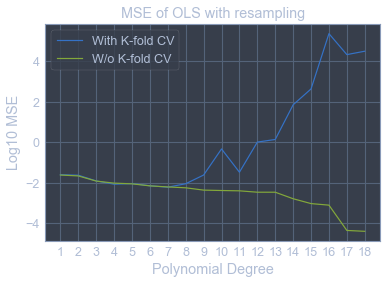

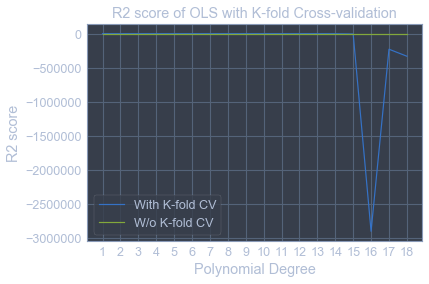

In [247]:
def MSE_kfold_OLS(max_deg):
    """Analyse the impact on the training- and testing error when including resampling"""
    data, xx, yy = create_frankefunction_data(20, 0.15)
    data = data.flatten()
    
    degrees = np.arange(1, max_deg+1, 1)
    
    MSEs = np.zeros(len(degrees)) # MSE values
    R2s = np.copy(MSEs) # R2 values
    for (idx, deg) in enumerate(degrees):
        X = np.polynomial.polynomial.polyvander2d(xx.flatten(), yy.flatten(), [deg, deg])
    
        # perform the K-fold cross-validation with 5 folds and unpack the results
        result = Kfold_CV(data, X, 5)[0:2]
        
        MSEs[idx] = result[0][0] # MSE of test data
        R2s[idx] = result[1][0] # R2 of test data
        
    MSE_wo, R2_wo = simple_OLS(max_deg)
    
    plt.plot(degrees, np.log10(MSEs), label="With K-fold CV")
    plt.plot(degrees, np.log10(MSE_wo), label="W/o K-fold CV")
    plt.xlabel("Polynomial Degree"); plt.ylabel("Log10 MSE")
    plt.title("MSE of OLS with resampling")
    plt.xticks(degrees)
    plt.legend()
    #plt.savefig("MSE_OLS_resam.png", dpi=500)
    
    plt.figure()
    plt.plot(degrees, R2s, label="With K-fold CV")
    plt.plot(degrees, R2_wo, label="W/o K-fold CV")
    plt.xlabel("Polynomial Degree"); plt.ylabel("R2 score")
    plt.title("R2 score of OLS with K-fold Cross-validation")
    plt.xticks(degrees)
    plt.legend()
    #plt.savefig("R2_OLS_resam.png", dpi=500)
    
MSE_kfold_OLS(18)
        
    

# c) Bias-variance tradeoff

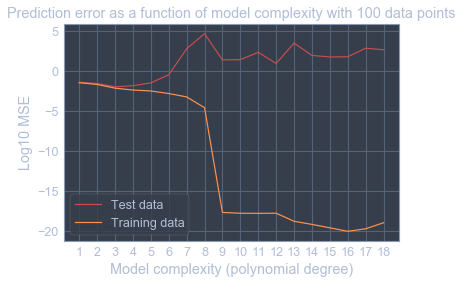

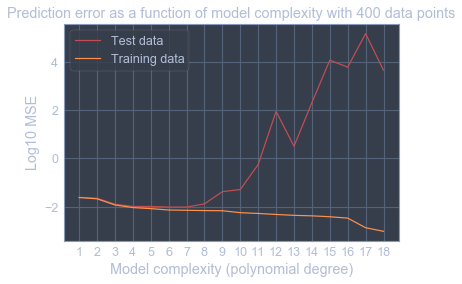

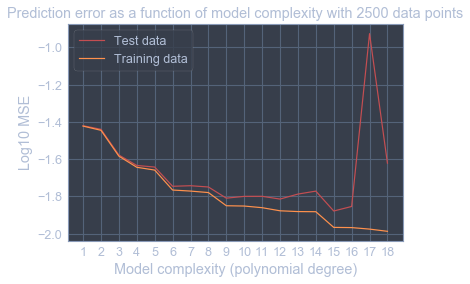

In [61]:
def bias_variance_study_OLS(n, max_deg):
    """
    Studying the bias-variance tradeoff in OLS regression
    n: no. of data points
    """
    # initialize the data
    data, xx, yy = create_frankefunction_data(n, 0.15)
    data = data.flatten()
    regress = regression()
    
    degrees = np.arange(1, max_deg+1, 1) # polynomial degrees (model complexity)
    
    # arrays for storing the MSE- and R2-scores, bias, variance, and error
    MSEs, R2s = np.zeros((2, len(degrees))), np.zeros((2, len(degrees)))
    bias = np.zeros(len(degrees))
    variance = np.copy(bias)
    error = np.copy(bias)
    
    K = 5 # no. of folds to perform in the K-fold cross-validation

    for (idx, deg) in enumerate(degrees):
        # create design matrix for given degree and perform the cross-validation
        X = np.polynomial.polynomial.polyvander2d(xx.flatten(), yy.flatten(), [deg, deg])
        #error[idx], bias[idx], variance[idx] = Kfold_CV_test(data, X, K)
        result = Kfold_CV(data, X, 5)[0:2]
        
        MSEs[:,idx] = result[0] # MSE of test data
        R2s[:,idx] = result[1] # R2 of test data
    
    plt.figure()
    plt.plot(degrees, np.log10(MSEs[0]), label="Test data", color="r")
    plt.plot(degrees, np.log10(MSEs[1]), label="Training data", color="y")
    plt.ylabel("Log10 MSE"); plt.xlabel("Model complexity (polynomial degree)")
    plt.title("Prediction error as a function of model complexity with {} data points" .format(n*n))
    plt.xticks(degrees)
    plt.legend()
    #plt.savefig("train_test_data_OLS_n={}.png" .format(n), dpi=500)
        
n = [10, 20, 50]
for i in n:
    bias_variance_study_OLS(i, 18)



# d) Ridge regression

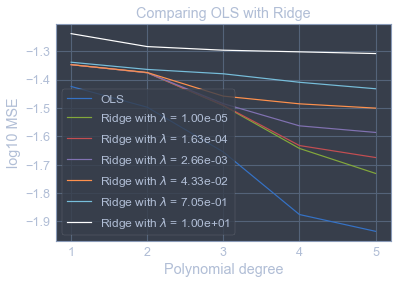

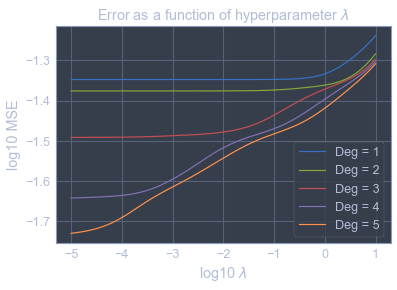

In [248]:
def simple_Ridge(max_deg):
    """Data prediction using Ridge regression without resampling"""
    # initialize the data
    data, xx, yy = create_frankefunction_data(20, 0.15)
    data = data.flatten()
    regress = regression()

    degrees = np.arange(1, max_deg+1) # polynomial degrees
    lambdas = np.logspace(-5, 1, 100) # hyperparameters to test
    
    MSEs = np.zeros((len(degrees), len(lambdas))) # MSE values
    R2s = np.copy(MSEs) # R2 values
    
    for (idx, deg) in enumerate(degrees):
        # create the design matrix for the given degree
        X = np.polynomial.polynomial.polyvander2d(xx.flatten(), yy.flatten(), [deg, deg])
        
        for j in range(len(lambdas)):
        
            # calculate the parameters and predict
            beta_Ridge = regress.Ridge(data, X, lambdas[j])
            model = X @ beta_Ridge

            MSEs[idx, j] = regress.MSE(data, model)
            R2s[idx, j] = regress.R2(data, model)
        
    MSE_OLS = simple_OLS(max_deg)[0] # for comparing with OLS
    plt.figure()
    plt.plot(degrees, np.log10(MSE_OLS), label="OLS")
    
    for j in range(len(lambdas[0::20])):
        j *= 20
        plt.plot(degrees, np.log10(MSEs[:,j]), label="Ridge with $\lambda$ = %.2e" %lambdas[j])
    plt.plot(degrees, np.log10(MSEs[:,-1]), label="Ridge with $\lambda$ = %.2e" %lambdas[-1], color="w")

    plt.xlabel("Polynomial degree"); plt.ylabel("log10 MSE")
    plt.xticks(degrees)
    plt.title("Comparing OLS with Ridge")
    plt.legend(prop={'size': 12})
    #plt.savefig("compare simple_ridge_with_simple_OLS.png", dpi=500)
    
    plt.figure()
    for i in range(len(degrees)):
        plt.plot(np.log10(lambdas), np.log10(MSEs[i,:]), label="Deg = %g" %degrees[i])
    plt.xlabel("log10 $\lambda$")
    plt.ylabel("log10 MSE")
    plt.title("Error as a function of hyperparameter $\lambda$")
    plt.legend()
    #plt.savefig("MSE_ridge_lambda_deg=5_test.png", dpi=500)
    
    
simple_Ridge(5)

In [249]:
def Kfold_CV_Ridge(data, X, K, lambdas):
    """K-fold cross validation for the ridge regressor"""
    regress = regression()
        
    # for storing the sum of the MSE and R2-scores. index 0: test data, index 1: training data
    R2_avg = np.zeros((2, len(lambdas)))  
    MSE_avg = np.zeros((2, len(lambdas)))
    
    # create array of indices, shuffle, and split into K lists
    idx = np.linspace(0, len(data)-1, len(data), dtype=np.int64)
    np.random.shuffle(idx)
    shuffled_split_idx = np.array_split(idx, K)

    
    for j in range(len(lambdas)):
        
        for i in range(K):

            # split into test data
            X_test = X[shuffled_split_idx[i]]
            data_test = data[shuffled_split_idx[i]]

            # split into training data
            X_train = np.array([X[k] for k in idx if k not in shuffled_split_idx[i]])
            data_train = np.array([data[k] for k in idx if k not in shuffled_split_idx[i]])

            betas = regress.Ridge(data_train, X_train, lambdas[j])
            data_model_train = X_train @ betas
            data_model_test = X_test @ betas

            # calculate the MSE and R2 scores and sum them
            MSE_avg[0, j] += regress.MSE(data_test, data_model_test)
            R2_avg[0, j] += regress.R2(data_test, data_model_test)

            MSE_avg[1, j] += regress.MSE(data_train, data_model_train)
            R2_avg[1, j] += regress.R2(data_train, data_model_train)
        
        MSE_avg[:,j] /= K


    #return the average MSE and R2 scores
    return MSE_avg, R2_avg/K, betas


In [250]:
def Ridge_kfold_study(max_deg):
    regress = regression()

    data, xx, yy = create_frankefunction_data(20, 0.15)
    data = data.flatten()
    
    lambdas = np.logspace(-5, 1, 10) # hyperparameters to test
    degrees = np.arange(1, max_deg+1)
    
    MSEs_train = np.zeros((len(degrees), len(lambdas)))
    MSEs_test = np.copy(MSEs_train)
    # R2s = np.copy(MSEs)


    for (idx, deg) in enumerate(degrees):
        # create design matrix for given degree
        X = np.polynomial.polynomial.polyvander2d(xx.flatten(), yy.flatten(), [deg, deg])
        
        result = Kfold_CV_Ridge(data, X, 5, lambdas)
        MSEs_test[idx,:], MSEs_train[idx,:] = Kfold_CV_Ridge(data, X, 5, lambdas)[0]


    
    """ contour plots """
    # test data
    plt.figure()
    plt.contourf(np.log10(lambdas), degrees,  np.log10(MSEs_test))
    plt.colorbar(label="log10 MSE")
    plt.grid(False)
    plt.xlabel("log10 $\lambda$"); plt.ylabel("Polynomial degree")
    plt.title("Contour plot of Ridge with test data")
    #plt.savefig("Ridge_contour_test.png", dpi=500)

    # training data
    plt.figure()
    plt.contourf(np.log10(lambdas), degrees,  np.log10(MSEs_train))
    plt.colorbar(label="log10 MSE")
    plt.grid(False)
    plt.xlabel("log10 $\lambda$"); plt.ylabel("Polynomial degree")
    plt.title("Contour plot of Ridge with training data")
    #plt.savefig("Ridge_contour_train.png", dpi=500)
    
    """ regular plots """
    fig1 = plt.figure()
    fig2 = plt.figure()
    ax1 = fig1.gca()
    ax2 = fig2.gca()
    for i in range(0, len(lambdas), 20):
        ax1.plot(degrees, np.log10(MSEs_test[:,i]), label="$\lambda$ = %.2e" %lambdas[i])
        ax2.plot(degrees, np.log10(MSEs_train[:,i]))
        
    ax1.set_title("Test data")
    ax1.set_xlabel("Polynomial degree"); ax1.set_ylabel("log10 MSE")
    ax1.set_xticks(degrees)
    ax2.set_title("Training data")
    ax2.set_xlabel("Polynomial degree"); ax2.set_ylabel("log10 MSE")
    ax2.set_xticks(degrees)
    fig1.legend()
    fig2.legend()
    
    #fig1.savefig("ridge_kfold_Cv_test.png", dpi=500)
    #fig2.savefig("ridge_kfold_Cv_train.png", dpi=500)
    
#Ridge_kfold_study(18)

# e): Lasso Regression

C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7287490943448018, tolerance: 0.0044687075035627815
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.445345361711845, tolerance: 0.0044687075035627815
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.181618416381144, tolerance: 0.0044687075035627815
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.64028339525619, tolerance: 0.0044687075035627815
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5605914047795477, tolerance: 0.0044687075035627815
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.455732711929113, tolerance: 0.0044687075035627815
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. D

C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015544534039975133, tolerance: 0.0044687075035627815
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011048079053711746, tolerance: 0.0044687075035627815
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010402832230010262, tolerance: 0.0044687075035627815
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

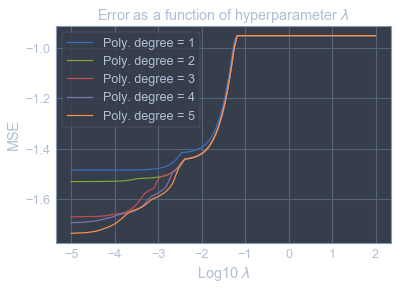

In [46]:
def simple_lasso(max_deg):
    """Data prediction using Lasso regression without resampling"""
    # initialize the data
    data, xx, yy = create_frankefunction_data(20, 0.15)
    data = data.flatten()
    regress = regression()

    degrees = np.arange(1, max_deg+1)         # polynomial degrees
    lambdas = np.logspace(-5, 2, 100) # Lasso parameters

    MSEs = np.zeros((len(degrees), len(lambdas))) # MSE values
    R2s = np.copy(MSEs) # R2 values

    
    for (idx, deg) in enumerate(degrees):
        # create the design matrix for the given degree
        X = np.polynomial.polynomial.polyvander2d(xx.flatten(), yy.flatten(), [deg, deg])
        
        for j in range(len(lambdas)):
            # using the Lasso module from scikit-learn
            lasso_model = Lasso(alpha=lambdas[j])
            
            lasso_model.fit(X, data)
            # predict the values
            model = lasso_model.predict(X)

            # calculate the error and R2 score
            MSEs[idx, j] = regress.MSE(data, model)
            R2s[idx, j] = regress.R2(data, model)
        
    
    plt.figure()
    for i in range(5):
        plt.plot(np.log10(lambdas), np.log10(MSEs[i,:]), label="Poly. degree = {}" .format(i+1))
    plt.xlabel("Log10 $\lambda$")
    plt.ylabel("MSE")
    plt.title("Error as a function of hyperparameter $\lambda$")
    plt.legend()
    plt.savefig("simple_lasso.png")
    
    
simple_lasso(5)

In [319]:
def Kfold_CV_Lasso(data, X, K, lambdas):
    regress = regression()
        
    # for storing the sum of the MSE and R2-scores. index 0: test data, index 1: training data
    R2_avg = np.zeros((2, len(lambdas)))  
    MSE_avg = np.zeros((2, len(lambdas)))
    
    # create array of indices, shuffle, and split into K lists
    idx = np.linspace(0, len(data)-1, len(data), dtype=np.int64)
    np.random.shuffle(idx)
    shuffled_split_idx = np.array_split(idx, K)

    for j in range(len(lambdas)):
        # initialize the scikit lasso model
        lasso_model = Lasso(alpha=lambdas[j])
        
        for i in range(K):
            # split into test data
            X_test = X[shuffled_split_idx[i]]
            data_test = data[shuffled_split_idx[i]]

            # split into training data
            X_train = np.array([X[k] for k in idx if k not in shuffled_split_idx[i]])
            data_train = np.array([data[k] for k in idx if k not in shuffled_split_idx[i]])


            # train the model
            lasso_model.fit(X_train, data_train)

            # predict the values
            data_model_train = lasso_model.predict(X_train)
            data_model_test = lasso_model.predict(X_test)

            # calculate the MSE and R2 scores and sum them
            MSE_avg[0, j] += regress.MSE(data_test, data_model_test)
            R2_avg[0, j] += regress.R2(data_test, data_model_test)

            MSE_avg[1, j] += regress.MSE(data_train, data_model_train)
            R2_avg[1, j] += regress.R2(data_train, data_model_train)


        MSE_avg[:,j] /= K
    #return the average MSE and R2 scores
    return MSE_avg, R2_avg/K, lasso_model.coef_


C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.675636655092771, tolerance: 0.0034757678564562348
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8520269827752274, tolerance: 0.00323187587949639
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8269473302845185, tolerance: 0.0033019012748417794
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. D

C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006349983747552912, tolerance: 0.0032838935563608957
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2080472622358274, tolerance: 0.003530935787505631
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3351595978039037, tolerance: 0.003396964994441666
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09196927421920975, tolerance: 0.003235917592931577
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1871845158491032, tolerance: 0.0032470841982090064
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.286632599495041, tolerance: 0.0032552739062836297
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations.

C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0680916202274977, tolerance: 0.0033958882457987556
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008366718083501645, tolerance: 0.0033893062735109157
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3426598012635766, tolerance: 0.003349141010734774
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iteration

C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020578559496477133, tolerance: 0.0031635241000360155
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030700604126516318, tolerance: 0.0034190152029400724
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04231943365237889, tolerance: 0.003453706875445414
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterat

C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7551893828369383, tolerance: 0.0033928629007556896
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.776659100279253, tolerance: 0.003603419461554053
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3988040379402253, tolerance: 0.003221628319428379
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. D

C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036544023528559677, tolerance: 0.003297291425499782
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0207044585177356, tolerance: 0.0034275355628737977
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6825184402586486, tolerance: 0.003096967191407483
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iteration

C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08430426624664822, tolerance: 0.0031714100204646425
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07566040401416796, tolerance: 0.003222800578103256
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11335017332519648, tolerance: 0.0033351729345905998
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iteratio

C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3468404529583715, tolerance: 0.0029836489892921592
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.559471897573575, tolerance: 0.003543445051491543
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1552286376233174, tolerance: 0.0033857357644393577
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09408237177422318, tolerance: 0.003540955311857269
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08631390943568373, tolerance: 0.0031578025573909783
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006928162322823894, tolerance: 0.003540955311857269
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iteratio

C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4255292194744, tolerance: 0.0032619422959192287
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0569980437640112, tolerance: 0.003017047074829413
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14385203435949556, tolerance: 0.0036716468523597325
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. D

C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7749213348774537, tolerance: 0.003243887285464744
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8238924633458615, tolerance: 0.003454045999041106
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6463667543013445, tolerance: 0.003221863689476179
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. D

C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020642704674807888, tolerance: 0.0033336837443648897
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05800865029926161, tolerance: 0.003318610421930619
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06646175422142431, tolerance: 0.003403409902716773
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iteratio

C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3309824701213513, tolerance: 0.0032222916963657684
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.39138507242451, tolerance: 0.0033133565288563037
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.448880563337023, tolerance: 0.003336471820275758
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Du

C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0956135754882439, tolerance: 0.003318538109202861
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07166975779875884, tolerance: 0.003314402590157356
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03947228255717228, tolerance: 0.0034945835266215826
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.503188895407707, tolerance: 0.0033710758705510686
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.476871087467661, tolerance: 0.003294405295325311
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.408376246575025, tolerance: 0.003390783174336953
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dua

C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07078216097816714, tolerance: 0.003188972606914699
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14060947972597226, tolerance: 0.003337361580990869
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.17139586159942954, tolerance: 0.0033188340487985833
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iteration

C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.333748995503326, tolerance: 0.003455208695415921
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2828474764757054, tolerance: 0.0032688862018867243
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3022115642306105, tolerance: 0.0033851655750996353
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.29270231606538566, tolerance: 0.003266812217002572
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004355276334054636, tolerance: 0.003266812217002572
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1852259542311074, tolerance: 0.0032582724206370248
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iteration

C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3297141821829905, tolerance: 0.00348044064935102
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.32409234708442, tolerance: 0.00333751119947962
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.071680395199923, tolerance: 0.0032824209772786346
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duali

C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.40294195385981446, tolerance: 0.0033806135124139452
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.48691907535560564, tolerance: 0.00338633064884517
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3144992787260197, tolerance: 0.0033537872854517547
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

No handles with labels found to put in legend.


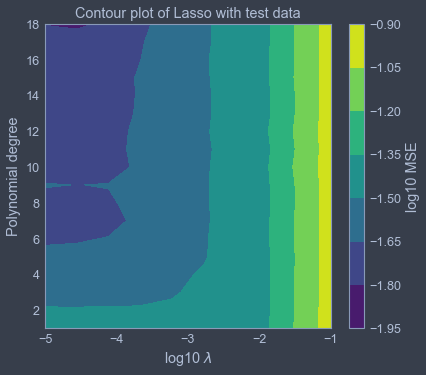

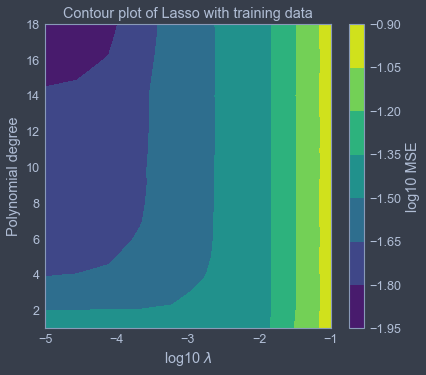

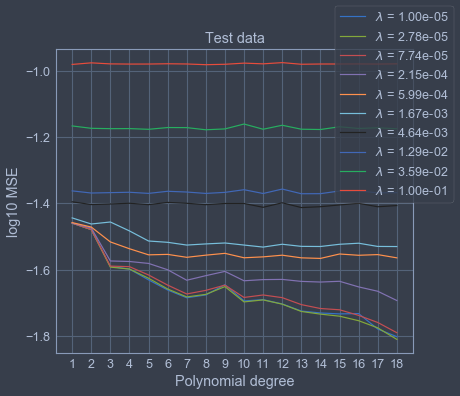

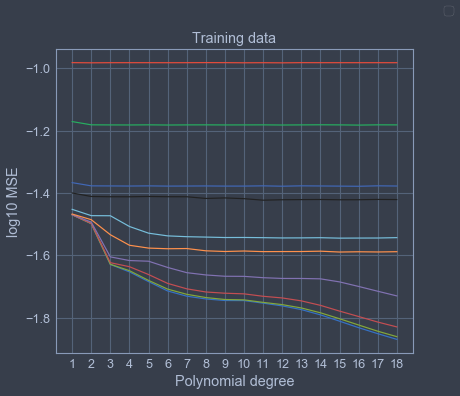

In [268]:
def Lasso_kfold_study(max_deg):
    regress = regression()

    data, xx, yy = create_frankefunction_data(20, 0.15)
    data = data.flatten()
    
    lambdas = np.logspace(-5, -1, 10) # hyperparameters to test

    degrees = np.arange(1, max_deg+1)
    
    MSEs_train = np.zeros((len(degrees), len(lambdas)))
    MSEs_test = np.copy(MSEs_train)
    # R2s = np.copy(MSEs)

    for (idx, deg) in enumerate(degrees):
        # create design matrix for given degree
        X = np.polynomial.polynomial.polyvander2d(xx.flatten(), yy.flatten(), [deg, deg])
        
        result = Kfold_CV_Lasso(data, X, 5, lambdas)
        MSEs_test[idx,:], MSEs_train[idx,:] = Kfold_CV_Lasso(data, X, 5, lambdas)[0]

        
    

    
    """ contour plots """
    # test data
    plt.figure()
    plt.contourf(np.log10(lambdas), degrees,  np.log10(MSEs_test))
    plt.colorbar(label="log10 MSE")
    plt.grid(False)
    plt.xlabel("log10 $\lambda$"); plt.ylabel("Polynomial degree")
    plt.title("Contour plot of Lasso with test data")
    plt.savefig("Lasso_contour_test.png", dpi=500)

    # training data
    plt.figure()
    plt.contourf(np.log10(lambdas), degrees,  np.log10(MSEs_train))
    plt.colorbar(label="log10 MSE")
    plt.grid(False)
    plt.xlabel("log10 $\lambda$"); plt.ylabel("Polynomial degree")
    plt.title("Contour plot of Lasso with training data")
    plt.savefig("Lasso_contour_train.png", dpi=500)
    
    """ regular plots """
    fig1 = plt.figure()
    fig2 = plt.figure()
    ax1 = fig1.gca()
    ax2 = fig2.gca()
    for i in range(0, len(lambdas)):
        ax1.plot(degrees, np.log10(MSEs_test[:,i]), label="$\lambda$ = %.2e" %lambdas[i])
        ax2.plot(degrees, np.log10(MSEs_train[:,i]))
        
    ax1.set_title("Test data")
    ax1.set_xlabel("Polynomial degree"); ax1.set_ylabel("log10 MSE")
    ax1.set_xticks(degrees)
    ax2.set_title("Training data")
    ax2.set_xlabel("Polynomial degree"); ax2.set_ylabel("log10 MSE")
    ax2.set_xticks(degrees)
    fig1.legend()
    fig2.legend()
    
    fig1.savefig("Lasso_kfold_Cv_test.png", dpi=500)
    fig2.savefig("Lasso_kfold_Cv_train.png", dpi=500)
    
Lasso_kfold_study(18)

# COnfidence intervals

C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.1930216086739485, tolerance: 0.0045839826737679905
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.444627412760518, tolerance: 0.00426554638672959
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.278247701948654, tolerance: 0.004141115918529655
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dua

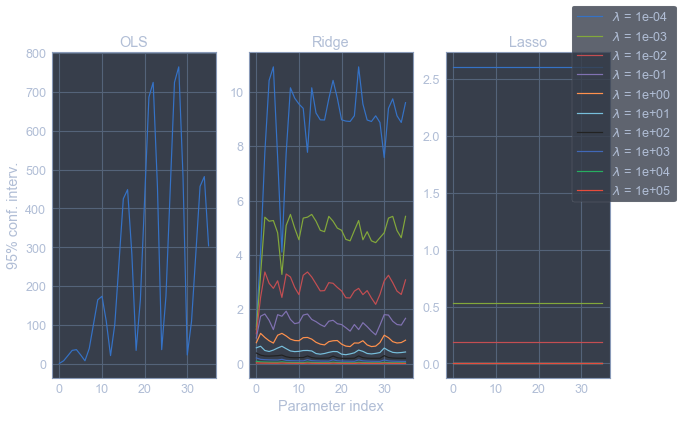

In [238]:
def confidenceintervals():
    """Calculate the confidence interval of the beta-parameters for 
    OLS, Ridge, and Lasso regression on the FrankeFunction data set
    with polynomial degree 5"""
    
    lambdas = np.logspace(-4, 5, 10) # hyperparameters to test for
    deg = 5 # polynomial degree
    K = 10
    # initialize data
    data, xx, yy = create_frankefunction_data(20, 0.15) 
    data = data.flatten()
    regress = regression()
    
    X = np.polynomial.polynomial.polyvander2d(xx.flatten(), yy.flatten(), [5, 5]) # create design matrix for given degree
    
    # initialize arrays for storing the variances
    Ridge_variance = np.zeros((len(lambdas), 36))
    Lasso_variance = np.copy(Ridge_variance)
    Lasso_coefs = np.zeros(36)
    
    # perform a k-fold cross-validation in order to get an estimate of the lasso beta-variances
    kfold = KFold(n_splits=K)

    
    # calculate the variances of the parameters for each model
    OLS_variance = regress.beta_variance(X, 0)
    for (idx, lam) in enumerate(lambdas):
        Ridge_variance[idx] = regress.beta_variance(X, lam)
        
        clf = Lasso(alpha=lam)
        Lasso_coefs = 0
        for train_inds, test_inds in kfold.split(X):
            Xtrain = X[train_inds]
            Ztrain = data[train_inds]

            Xtest = X[test_inds]
            Ztest = data[test_inds]

            clf.fit(Xtrain, Ztrain)

            Lasso_coefs += clf.coef_
            
        Lasso_variance[idx] = np.mean((Lasso_coefs/K - np.mean(Lasso_coefs/K))**2)
        
    # calculate the 95% confidence intervals
    CI_ols = 1.96*np.sqrt(OLS_variance)
    CI_Ridge = 1.96*np.sqrt(Ridge_variance)
    CI_Lasso = 1.96*np.sqrt(Lasso_variance)
    
    # plotting
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=False, figsize=(10, 6))
    ax1.plot(np.arange(0, 36), CI_ols)
    for i in range(10):
        ax2.plot(np.arange(0, 36), CI_Ridge[i])
        ax3.plot(np.arange(0, 36), CI_Lasso[i], label="$\lambda$ = %.0e" %lambdas[i])
        
    ax1.set_title("OLS"); ax2.set_title("Ridge"); ax3.set_title("Lasso")
    ax2.set_xlabel("Parameter index")
    ax1.set_ylabel("95% conf. interv.")
    
    fig.legend()
    fig.savefig("confidence_intervals_deg5.png", dpi=500)
    

confidenceintervals()

# f) Introducing real data

In [277]:
from imageio import imread


def get_terrain_data(slicex=180, slicey=90, plot=False):
    """Extract an image of size 20x20. Thanks to the guy on piazza."""
    terrain = imread("SRTM_data_Norway_2.tif")
    
    new_terrain_data = terrain[0::slicex, 0::slicey]
    x = np.linspace(0, 1, new_terrain_data.shape[1])
    y = np.linspace(0, 1, new_terrain_data.shape[0])
    xx, yy = np.meshgrid(x, y)
    
    if plot:
        plt.figure()
        plt.title("Terrain over Norway")
        plt.imshow(terrain[0:slice, 0:slice], cmap="gray")
        plt.xlabel("X"); plt.ylabel("Y")
        plt.show()
        
    new_terrain_data = (new_terrain_data - np.min(new_terrain_data)) / (np.max(new_terrain_data) - np.min(new_terrain_data))  # scale the data
    return new_terrain_data, xx, yy


def reconstruct_image(data, shape):
    """Reconstruct the flattened inout data to a 2d matrix"""
    new_data = np.zeros((shape))

    for i in range(shape[0]):
        for j in range(shape[1]):
            new_data[i, j] = data[i*shape[1] + j]
            
    return new_data
            
def create_design_matrix(xx, yy, deg):
    return np.polynomial.polynomial.polyvander2d(xx.flatten(), yy.flatten(), [deg, deg])


regress = regression()

(441, 36)
0.011759661770803415


Text(0.5, 0.98, 'Raw data vs. parametrized with OLS')

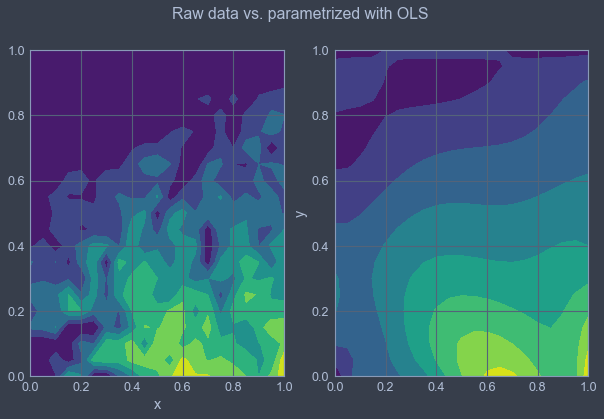

In [326]:
"""Contour plots of the terrain data before and after OLS"""
test_data, xx, yy = get_terrain_data()

test_data_flat = test_data.flatten()

X = create_design_matrix(xx, yy, 5)
print(X.shape)
betas = regress.OSL(test_data_flat, X)
test_data_pred = X @ betas
print(regress.MSE(test_data_flat, test_data_pred))
    
test_data_new = reconstruct_image(test_data_pred, test_data.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.contourf(xx, yy, test_data)
ax2.contourf(xx, yy, test_data_new)

ax1.set_xlabel("x"); ax2.set_ylabel("y")
fig.suptitle("Raw data vs. parametrized with OLS")
#fig.savefig("terrain_result.png",dpi=500)


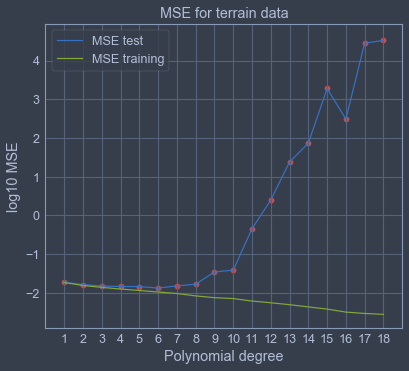

In [285]:
""" OlS study on Real data"""

def OLS_realdata(max_deg):
    
    imagedata, xx, yy = get_terrain_data()
    imagedataf = imagedata.flatten()
    
    degrees = np.arange(1, max_deg+1)
    
    MSEs = np.zeros(len(degrees)) # MSE values
    MSEs_train = np.copy(MSEs)
    R2s = np.copy(MSEs) # R2 values
    
    for (idx, deg) in enumerate(degrees):
        X = create_design_matrix(xx, yy, deg)
        
        # perform the K-fold cross-validation with 5 folds and unpack the results
        result = Kfold_CV(imagedataf, X, 5)
        
        MSEs[idx] = result[0][0] # MSE of test data
        MSEs_train[idx] = result[0][1]
        R2s[idx] = result[1][0] # R2 of test data
        
        
    plt.plot(degrees, np.log10(MSEs), label="MSE test")
    plt.plot(degrees, np.log10(MSEs_train), label="MSE training")
    plt.scatter(degrees, np.log10(MSEs), color="r")
    plt.ylabel("log10 MSE")
    
    
    plt.legend()
    #f.suptitle("MSE and R2 of OLS with n = {}" .format(slice*slice))
    plt.xlabel("Polynomial degree")
    plt.xticks(degrees)
    plt.title("MSE for terrain data")

    plt.savefig("OLS_terraindata.png", dpi=500)
    
"""n = [10, 50, 100]
for i in n:
    OLS_realdata(18, i)"""

OLS_realdata(18)

No handles with labels found to put in legend.


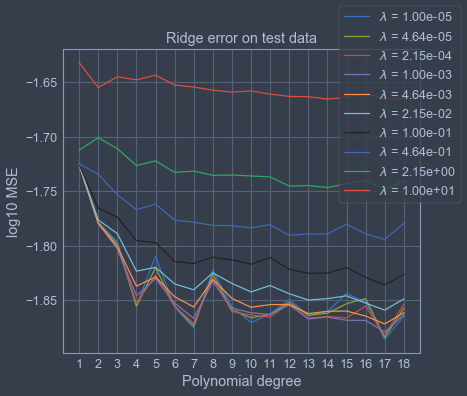

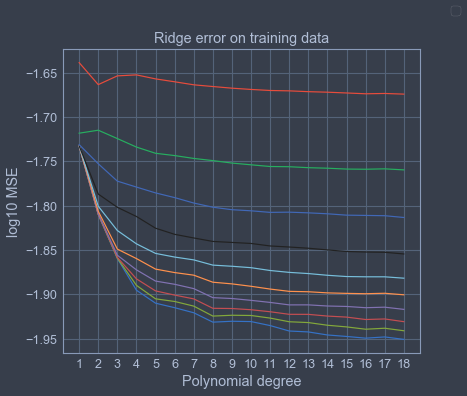

In [327]:
"""Ridge study on real data"""

def Ridge_realdata(max_deg):
    """Perform a ridge regression analysis on the terrain data"""
    
    # initialize the data
    imagedata, xx, yy = get_terrain_data()
    imagedataf = imagedata.flatten()
    

    lambdas = np.logspace(-5, 1, 10) # hyperparameters to test
    degrees = np.arange(1, max_deg+1) # polynomial degrees

    MSEs_train = np.zeros((len(degrees), len(lambdas)))
    MSEs_test = np.copy(MSEs_train)

    for (idx, deg) in enumerate(degrees):
        # create design matrix for given degree
        X = create_design_matrix(xx, yy, deg)

        # perform the cross-validation and extract the training- and test error
        result = Kfold_CV_Ridge(imagedataf, X, 5, lambdas)
        MSEs_test[idx,:] = result[0][0] 
        MSEs_train[idx,:] = result[0][1]
        betas = result[-1]


    """ regular plots """
    fig1 = plt.figure()
    fig2 = plt.figure()
    ax1 = fig1.gca()
    ax2 = fig2.gca()
    for i in range(0, len(lambdas)):
        ax1.plot(degrees, np.log10(MSEs_test[:,i]), label="$\lambda$ = %.2e" %lambdas[i])
        ax2.plot(degrees, np.log10(MSEs_train[:,i]))

    ax1.set_title("Ridge error on test data")
    ax1.set_xlabel("Polynomial degree"); ax1.set_ylabel("log10 MSE")
    ax1.set_xticks(degrees)
    ax2.set_title("Ridge error on training data")
    ax2.set_xlabel("Polynomial degree"); ax2.set_ylabel("log10 MSE")
    ax2.set_xticks(degrees)
    fig1.legend()
    fig2.legend()

    #fig1.savefig("ridge_kfold_Cv_test_terrain.png", dpi=500)
    #fig2.savefig("ridge_kfold_Cv_train_terrain.png", dpi=500)

Ridge_realdata(18)

C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3054813945491661, tolerance: 0.0024642685099370842
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4709161506449095, tolerance: 0.0026189725090651587
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3884408941223327, tolerance: 0.0025569055556226143
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4020328060706757, tolerance: 0.0026136144590890894
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6235687850569787, tolerance: 0.0025448451392889354
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.475614860776343, tolerance: 0.00255381484925634
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. D

C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7989389763888526, tolerance: 0.002569105896932955
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5750263212993798, tolerance: 0.002572087846267506
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3085123047858516, tolerance: 0.0025735268302255355
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004853437177314568, tolerance: 0.002462544046046845
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00328628547290144, tolerance: 0.0024623553459324145
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00992586802867823, tolerance: 0.002679887119409409
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iteratio

C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09673625770224303, tolerance: 0.0025092990168827352
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1350054341216973, tolerance: 0.0024874132584161305
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006177932216488102, tolerance: 0.0027320216886555205
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterati

C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.139358992176855, tolerance: 0.002560084061774288
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.21636998520133144, tolerance: 0.0026274873982768477
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08496817580276783, tolerance: 0.002481129718265775
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations.

C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014198544522642464, tolerance: 0.0025877918414055
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005407997777133744, tolerance: 0.0025744526099572545
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009683003775247556, tolerance: 0.002592616256101575
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iteratio

C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.637352247460813, tolerance: 0.0026789539383421422
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6743250182212333, tolerance: 0.0025450495885500925
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.796792936016443, tolerance: 0.0024478581186432014
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7118620105220232, tolerance: 0.0026347910257993423
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08679121361198527, tolerance: 0.0025246963896377486
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10629427092943189, tolerance: 0.0023881428308195414
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iteratio

C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008060597906307088, tolerance: 0.0025176714871329945
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00753591557393829, tolerance: 0.0025467469388530677
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.664436834020027, tolerance: 0.0025759999077736534
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iteratio

C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7001312261816062, tolerance: 0.0024731621041067238
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.795386918821917, tolerance: 0.0025918064984631877
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23233239205605027, tolerance: 0.002571191146646193
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations.

C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.17327214631332355, tolerance: 0.0025102583962288718
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13140560353712605, tolerance: 0.002472777018663043
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1421509830554064, tolerance: 0.0025658824539344454
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iteration

C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.697611490501955, tolerance: 0.0025418794732982833
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5672462635545796, tolerance: 0.0025368939387863595
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5944208373745399, tolerance: 0.0025933956941564854
  positive)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations.

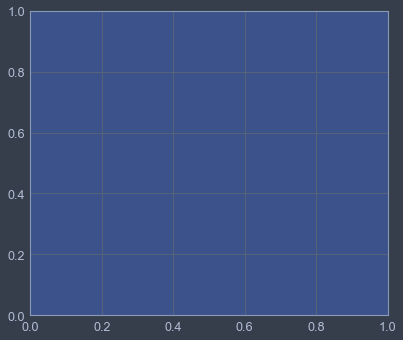

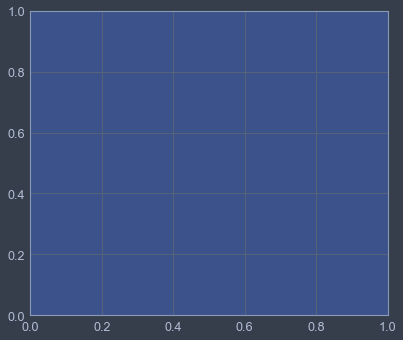

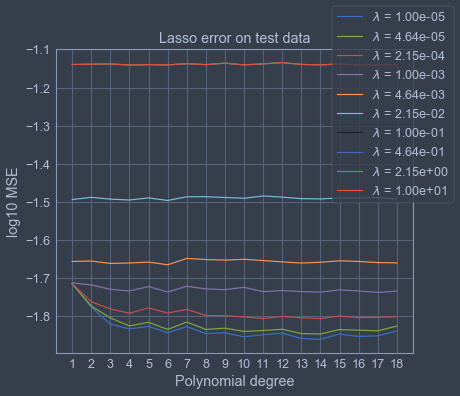

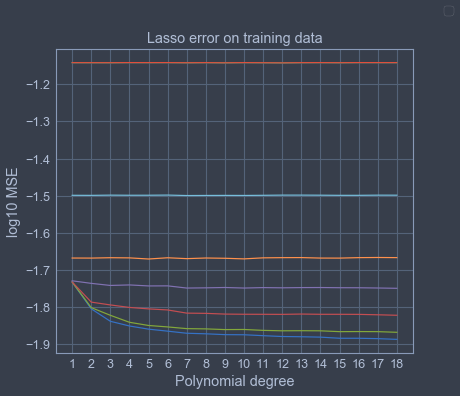

In [320]:
def Lasso_kfold_study(max_deg):
    """Lasso analysis of the terrain data using k-fold cross validation"""

    imagedata, xx, yy = get_terrain_data()
    imagedataf = imagedata.flatten()
    
    lambdas = np.logspace(-5, 1, 10) # hyperparameters to test

    degrees = np.arange(1, max_deg+1)
    
    MSEs_train = np.zeros((len(degrees), len(lambdas)))
    MSEs_test = np.copy(MSEs_train)

    for (idx, deg) in enumerate(degrees):
        # create design matrix for given degree
        X = np.polynomial.polynomial.polyvander2d(xx.flatten(), yy.flatten(), [deg, deg])
        
        result = Kfold_CV_Lasso(imagedataf, X, 5, lambdas)
        MSEs_test[idx,:], MSEs_train[idx,:] = Kfold_CV_Lasso(imagedataf, X, 5, lambdas)[0]
            
    

    """ regular plots """
    fig1 = plt.figure()
    fig2 = plt.figure()
    ax1 = fig1.gca()
    ax2 = fig2.gca()
    for i in range(0, len(lambdas)):
        ax1.plot(degrees, np.log10(MSEs_test[:,i]), label="$\lambda$ = %.2e" %lambdas[i])
        ax2.plot(degrees, np.log10(MSEs_train[:,i]))
        
    ax1.set_title("Lasso error on test data")
    ax1.set_xlabel("Polynomial degree"); ax1.set_ylabel("log10 MSE")
    ax1.set_xticks(degrees)
    ax2.set_title("Lasso error on training data")
    ax2.set_xlabel("Polynomial degree"); ax2.set_ylabel("log10 MSE")
    ax2.set_xticks(degrees)
    fig1.legend()
    fig2.legend()
    
    #fig1.savefig("Lasso_kfold_Cv_test_terrain.png", dpi=500)
    #fig2.savefig("Lasso_kfold_Cv_train_terrain.png", dpi=500)
    
Lasso_kfold_study(18)

# Tests

In [56]:
def test_OLS():
    """Compare the results of the implemented OLS function with the OLS solver from scikit"""
    
    data, xx, yy = create_frankefunction_data(20, 0.15)
    data = data.flatten()
    regress = regression()
    
    X = create_design_matrix(xx, yy, deg=5)
    
    """With own OLS:"""
    
    # calculate parameters from self-written OLS and make the prediction
    beta_OLS_test = regress.OSL(data, X)
    pred_OLS = X @ beta_OLS_test
    
    
    
    
    """With scikit"""
    
    # initialize model and fit data
    model = LinearRegression(fit_intercept=True)
    model.fit(X, data)
    

    # predict
    pred_OLS_scikit = model.predict(X)

    epsilon = 1e-8
    
    np.testing.assert_allclose(pred_OLS, pred_OLS_scikit, rtol=epsilon)
    print("OLS model successful to a tolerance of {}" .format(epsilon))
test_OLS()


OLS model successful to a tolerance of 1e-08


In [61]:
def test_Ridge():
    """Compare the results of the implemented OLS function with the OLS solver from scikit"""
    
    data, xx, yy = create_frankefunction_data(20, 0.15)
    data = data.flatten()
    regress = regression()
    
    X = create_design_matrix(xx, yy, deg=5)
    
    _lambda = 0.01
    """With own Ridge:"""
    
    # calculate parameters from self-written OLS and make the prediction
    beta_Ridge_test = regress.Ridge(data, X, _lambda)
    pred = X @ beta_Ridge_test
    
    
    """With scikit"""
    
    # initialize model and fit data
    model = Ridge(fit_intercept=False, alpha=_lambda)
    model.fit(X, data)
    

    # predict
    pred_Ridge_scikit = model.predict(X)

    epsilon = 1e-9
    
    np.testing.assert_allclose(pred, pred_Ridge_scikit, rtol=epsilon)
    print("Ridge model successful to a tolerance of {}" .format(epsilon))
test_Ridge()

Ridge model successful to a tolerance of 1e-09
